In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabula


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.plot import (
    plot_bar,
    plot_pie,
    heatmap,
    PRIMARY_CMAP,
    PRIMARY_HEX,
    SECONDARY_HEX,
    TERTIARY_HEX,
)

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/ct_claims"
OUTPUT_DATA_DIR = "./output_data/ct_claims"  # Set to None if you don't want to save non-required data for external use
NO_PLOT_TITLES = False  # If True, plots have no titles. Useful for cases where one wants titles rendered separately from underlying plots.

In [2]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

# 2022 Report (2021 Plan Year)

In [3]:
url = "https://portal.ct.gov/-/media/CID/1_Reports/2022-ConsumerReportCard.pdf"
pages = [7, 8] + list(range(29, 49 + 1)) + [52, 55, 56, 57, 58, 59]
dfs = tabula.read_pdf(url, stream=True, pages=pages)

## Enrollment Plots

In [4]:
enrollment_int_cols = [
    "fi_ind",
    "fi_sg",
    "fi_lg",
    "si_ind",
    "si_sg",
    "si_lg",
    "tot_ind",
    "tot_sg",
    "tot_lg",
]
enrollment_cols = ["insurer"] + enrollment_int_cols
hmo_enrollment_table = dfs[1].iloc[2:]
hmo_enrollment_table.columns = enrollment_cols
indemnity_enrollment_table = dfs[2].iloc[2:]
indemnity_enrollment_table.columns = enrollment_cols

In [5]:
def clean_and_cast_to_int(df: pd.DataFrame, int_cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for col in int_cols:
        df[col] = df[col].apply(lambda x: int(x.replace(",", "").replace("***", "")))
    return df

In [6]:
hmo_enrollment_table = clean_and_cast_to_int(hmo_enrollment_table, enrollment_int_cols)
indemnity_enrollment_table = clean_and_cast_to_int(
    indemnity_enrollment_table, enrollment_int_cols
)

In [7]:
hmo_enrollment_table

,insurer,fi_ind,fi_sg,fi_lg,si_ind,si_sg,si_lg,tot_ind,tot_sg,tot_lg
2,Aetna Health,0,1,60,0,0,141,0,1,201
3,Anthem,11732,337,1249,0,115,229675,11732,452,230924
4,ConnectiCare,2675,347,13290,0,0,0,2675,347,13290
5,Harvard,0,2947,1801,0,0,0,0,2947,1801
6,Oxford,0,2455,3052,0,0,0,0,2455,3052
7,Totals,14407,6087,19452,0,115,229816,14407,6202,249268


In [8]:
indemnity_enrollment_table

,insurer,fi_ind,fi_sg,fi_lg,si_ind,si_sg,si_lg,tot_ind,tot_sg,tot_lg
2,Aetna Life,0,1592,53395,0,14193,232833,0,15785,286228
3,Anthem,19699,24737,47834,0,0,742195,19699,24737,790029
4,Cigna H & L,0,6161,48389,0,1700,275907,0,7861,324296
5,ConnectiCare Benefits,72761,5400,0,0,0,0,72761,5400,0
6,ConnectiCare,2604,17177,28573,0,7868,3029,2604,25045,31602
7,HPHC,0,3344,7224,0,0,0,0,3344,7224
8,Oxford Health,0,41046,10274,0,0,0,0,41046,10274
9,United,0,2108,51983,0,0,0,0,2108,51983
10,Totals,95064,101565,247672,0,23761,1253964,95064,125326,1501636


In [9]:
def get_totals_dict(df: pd.DataFrame, group_label: str) -> dict:
    total_enrollment = df.iloc[-1][["tot_ind", "tot_sg", "tot_lg"]].sum(axis=0)

    total_si = df.iloc[-1][["si_sg", "si_lg"]].sum(axis=0)
    total_fi = df.iloc[-1][["fi_ind", "fi_sg", "fi_lg"]].sum(axis=0)
    total_ind = df.iloc[-1]["tot_ind"]
    total_sg = df.iloc[-1]["tot_sg"]
    total_lg = df.iloc[-1]["tot_lg"]
    insurers = {}
    for row in df.itertuples():
        if row.insurer != "Totals":
            insurers[row.insurer] = row.tot_ind + row.tot_sg + row.tot_lg

    assert total_si + total_fi == total_enrollment
    assert total_ind + total_sg + total_lg == total_enrollment
    assert sum(insurers.values()) == total_enrollment

    return {
        group_label: {
            "total": total_enrollment,
            "si": total_si,
            "fi": total_fi,
            "ind": total_ind,
            "sg": total_sg,
            "lg": total_lg,
            "insurers": insurers,
        }
    }

In [10]:
enrollments = {}
enrollments.update(get_totals_dict(hmo_enrollment_table, "hmo"))
enrollments.update(get_totals_dict(indemnity_enrollment_table, "indemnity"))

In [11]:
enrollments

{'hmo': {'total': 269877,
  'si': 229931,
  'fi': 39946,
  'ind': 14407,
  'sg': 6202,
  'lg': 249268,
  'insurers': {'Aetna Health': 202,
   'Anthem': 243108,
   'ConnectiCare': 16312,
   'Harvard': 4748,
   'Oxford': 5507}},
 'indemnity': {'total': 1722026,
  'si': 1277725,
  'fi': 444301,
  'ind': 95064,
  'sg': 125326,
  'lg': 1501636,
  'insurers': {'Aetna Life': 302013,
   'Anthem': 834465,
   'Cigna H & L': 332157,
   'ConnectiCare Benefits': 78161,
   'ConnectiCare': 59251,
   'HPHC': 10568,
   'Oxford Health': 51320,
   'United': 54091}}}

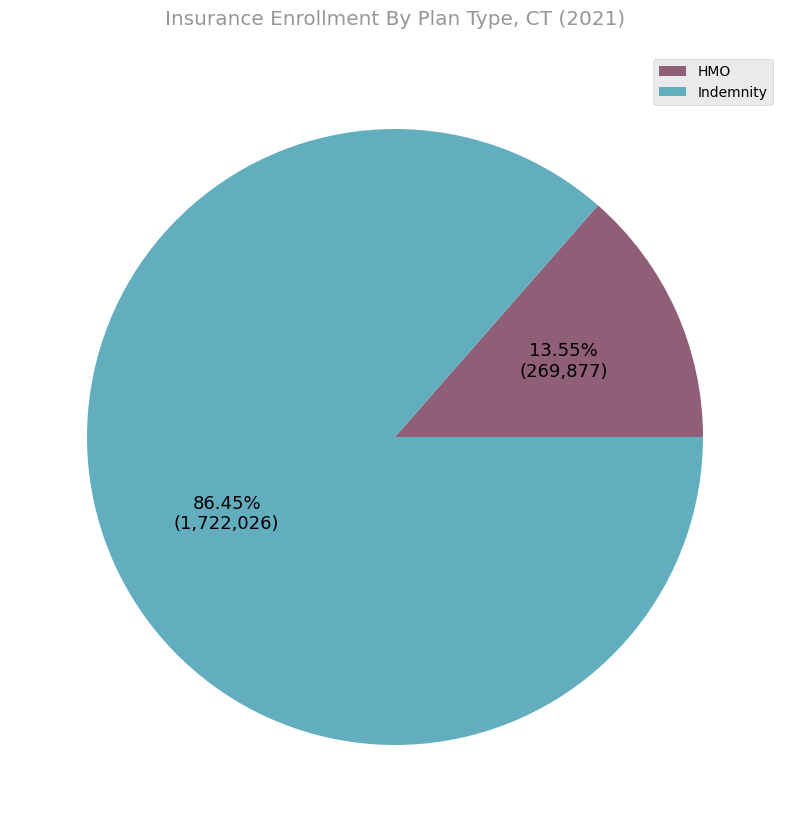

In [12]:
# Enrollment by Plan Type
title = "Insurance Enrollment By Plan Type, CT (2021)"
slice_names = ["HMO", "Indemnity"]
slice_vals = [enrollments["hmo"]["total"], enrollments["indemnity"]["total"]]
plot_pie(
    slice_names=slice_names,
    slice_vals=slice_vals,
    title=title if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_plan_type.png"),
)

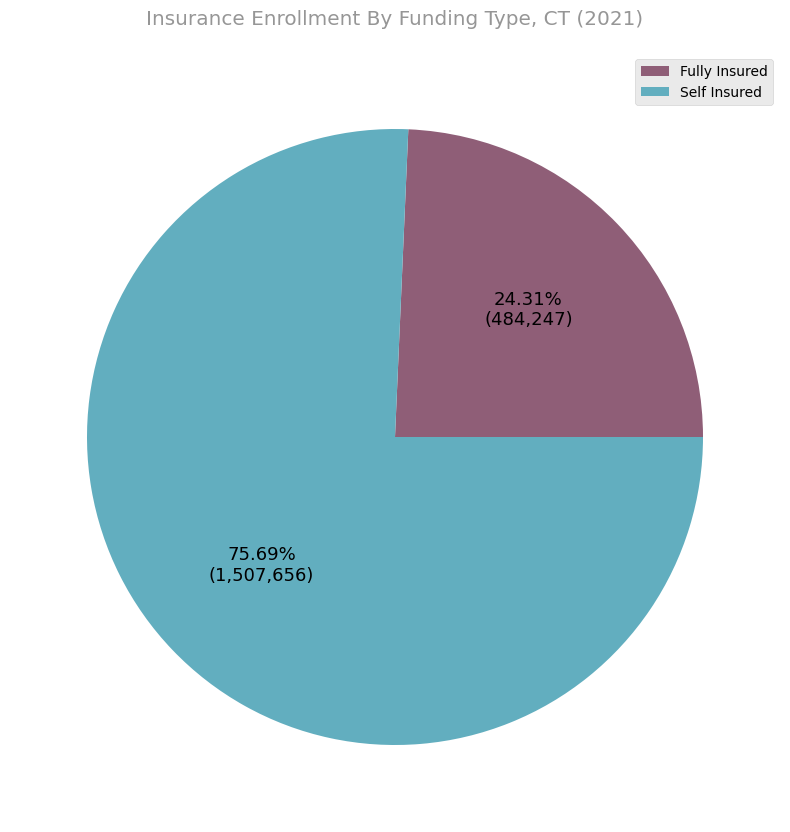

In [13]:
# Enrollment by Payer Type
title = "Insurance Enrollment By Funding Type, CT (2021)"
slice_names = ["Fully Insured", "Self Insured"]
slice_vals = [
    enrollments["hmo"]["fi"] + enrollments["indemnity"]["fi"],
    enrollments["hmo"]["si"] + enrollments["indemnity"]["si"],
]
plot_pie(
    slice_names=slice_names,
    slice_vals=slice_vals,
    title=title if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_payer_type.png"),
)

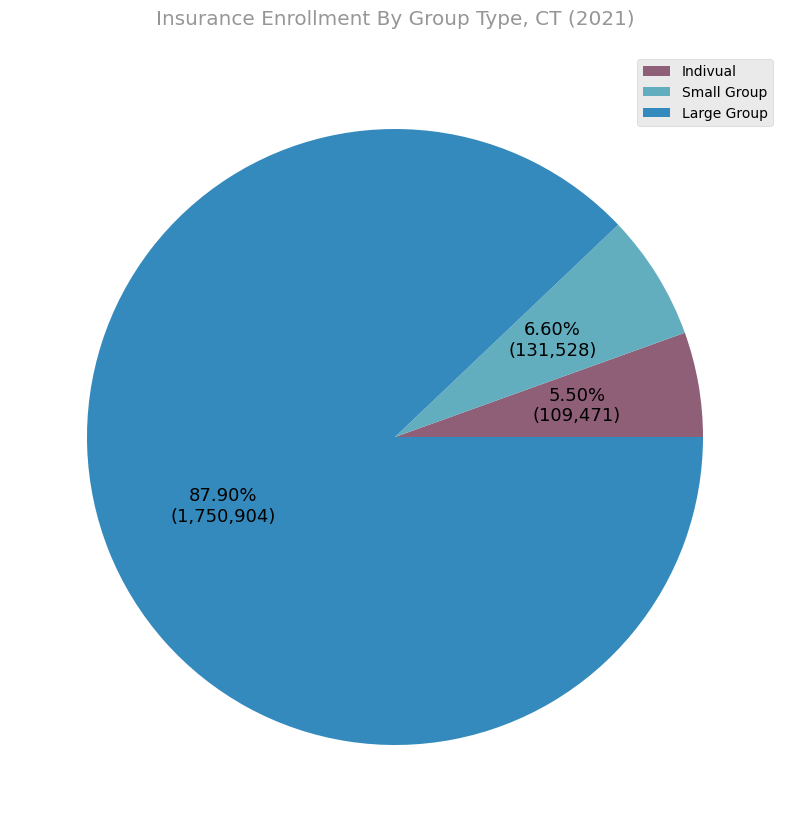

In [14]:
# Enrollment by Group Type
title = "Insurance Enrollment By Group Type, CT (2021)"
slice_names = ["Indivual", "Small Group", "Large Group"]
slice_vals = [
    enrollments["hmo"]["ind"] + enrollments["indemnity"]["ind"],
    enrollments["hmo"]["sg"] + enrollments["indemnity"]["sg"],
    enrollments["hmo"]["lg"] + enrollments["indemnity"]["lg"],
]
plot_pie(
    slice_names=slice_names,
    slice_vals=slice_vals,
    title=title if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_group_type.png"),
)

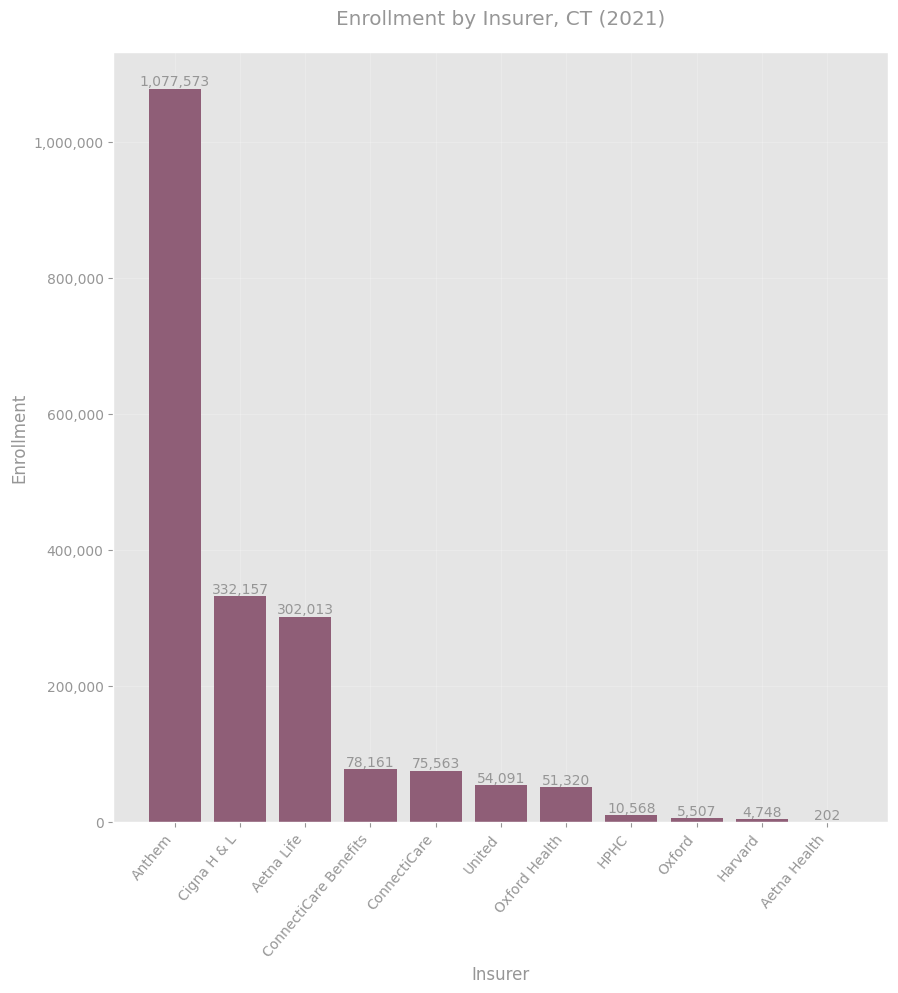

In [15]:
# Insurer breakdown by enrollment

# Get enrollment counts irrespective of plan type
x = enrollments["hmo"]["insurers"]
y = enrollments["indemnity"]["insurers"]
insurers = {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}
insurers = dict(sorted(insurers.items(), key=lambda item: item[1], reverse=True))


title = "Enrollment by Insurer, CT (2021)"
val_axis_label = "Enrollment"
cat_axis_label = "Insurer"

bar_names, bar_vals = list(insurers.keys()), insurers.values()
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_insurer.png"),
    bar_label=True,
    figsize=(10, 10),
)

## Claims Plots

In [16]:
# HMO Claim Denial Data
# Code to make one vomit. This PDF does not want to be parsed.
hmo_1 = dfs[-6]
hmo_2 = dfs[-5]
hmo = pd.concat([hmo_1, hmo_2]).reset_index(drop=True)

new_col_map = {
    "index": "insurer",
    1: "claims_received",
    3: "denials_not_covered",
    4: "denials_nmn",
    5: "denials_non_eligible_enrollee",
    6: "denials_incomplete",
    7: "denials_duplicate",
    8: "denials_other",
    17: "internal_appeals_not_covered",
    18: "internal_appeals_nmn",
    19: "internal_appeals_non_eligible_enrollee",
    20: "internal_appeals_incomplete",
    21: "internal_appeals_duplicate",
    22: "internal_appeals_other",
    31: "internal_appeals_rev_not_covered",
    32: "internal_appeals_rev_nmn",
    33: "internal_appeals_rev_non_eligible_enrollee",
    34: "internal_appeals_rev_incomplete",
    35: "internal_appeals_rev_duplicate",
    36: "internal_appeals_rev_other",
}
retain_cols = new_col_map.values()
hmo = hmo.T.reset_index().rename(columns=new_col_map)[retain_cols].iloc[1:]
hmo = hmo.fillna("0")
hmo = clean_and_cast_to_int(hmo, int_cols=[x for x in retain_cols if x != "insurer"])

In [17]:
# Indemnity Claim Denial Data
# Code to make one vomit. This PDF does not want to be parsed.
ind_1 = dfs[-3].drop(columns=[f"Unnamed: {i}" for i in range(0, 4)])
ind_2 = (
    dfs[-2]
    .drop(columns=[f"Unnamed: {i}" for i in range(0, 4)])
    .rename(columns={"Claim Denial Data (continued)": "Claim Denial Data"})
)
ind = pd.concat([ind_1, ind_2]).reset_index(drop=True)

new_col_map = {
    "index": "insurer",
    0: "claims_received",
    3: "denials_not_covered",
    4: "denials_nmn",
    5: "denials_non_eligible_enrollee",
    6: "denials_incomplete",
    7: "denials_duplicate",
    8: "denials_other",
    20: "internal_appeals_not_covered",
    21: "internal_appeals_nmn",
    22: "internal_appeals_non_eligible_enrollee",
    23: "internal_appeals_incomplete",
    24: "internal_appeals_duplicate",
    25: "internal_appeals_other",
    36: "internal_appeals_rev_not_covered",
    37: "internal_appeals_rev_nmn",
    38: "internal_appeals_rev_non_eligible_enrollee",
    39: "internal_appeals_rev_incomplete",
    40: "internal_appeals_rev_duplicate",
    41: "internal_appeals_rev_other",
}
retain_cols = new_col_map.values()
ind = ind.T.reset_index().rename(columns=new_col_map)[retain_cols].iloc[1:]
ind = clean_and_cast_to_int(ind, int_cols=[x for x in retain_cols if x != "insurer"])

In [18]:
def add_totals(df: pd.DataFrame) -> pd.DataFrame:
    prefixes = ["denials", "internal_appeals", "internal_appeals_rev"]
    for pfx in prefixes:
        df[pfx] = (
            df[f"{pfx}_not_covered"]
            + df[f"{pfx}_nmn"]
            + df[f"{pfx}_non_eligible_enrollee"]
            + df[f"{pfx}_incomplete"]
            + df[f"{pfx}_duplicate"]
            + df[f"{pfx}_other"]
        )

    # Conecticare Indemnity seems to have bad data
    # Or at least, it does not pass this filter
    udf = df[df["claims_received"] >= df["denials"]].copy()

    assert (udf["claims_received"] >= udf["denials"]).all()
    assert (udf["denials"] >= udf["internal_appeals"]).all()
    assert (udf["denials"] >= udf["internal_appeals_rev"]).all()
    return udf


def add_rates(df: pd.DataFrame) -> pd.DataFrame:
    df["denial_rate"] = df["denials"] / df["claims_received"]
    df["internal_appeal_rate"] = df["internal_appeals"] / df["denials"]
    df["internal_appeal_overturn_rate"] = (
        df["internal_appeals_rev"] / df["internal_appeals"]
    )
    return df

In [19]:
def get_denials_dict(df: pd.DataFrame, group_label: str) -> dict:
    claims_received = df["claims_received"].sum()
    claims_denied = df["denials"].sum()
    claims_internally_appealed = df["internal_appeals"].sum()
    claims_internally_overturned = df["internal_appeals_rev"].sum()
    overall_denial_rate = claims_denied / claims_received
    overall_internal_appeal_rate = claims_internally_appealed / claims_denied
    overall_internal_appeal_overturn_rate = (
        claims_internally_overturned / claims_internally_appealed
    )

    insurers = {}
    for row in df.itertuples():
        insurers[row.insurer] = {
            "claims_received": row.claims_received,
            "claims_denied": row.denials,
            "claims_appealed": row.internal_appeals,
            "claims_overturned": row.internal_appeals_rev,
            "denial_rate": row.denial_rate,
            "internal_appeal_rate": row.internal_appeal_rate,
            "internal_appeal_success_rate": row.internal_appeal_overturn_rate,
        }

    return {
        group_label: {
            "claims_received": claims_received,
            "claims_denied": claims_denied,
            "claims_appealed": claims_internally_appealed,
            "claims_overturned": claims_internally_overturned,
            "denial_rate": overall_denial_rate,
            "internal_appeal_rate": overall_internal_appeal_rate,
            "internal_appeal_success_rate": overall_internal_appeal_overturn_rate,
            "insurers": insurers,
        }
    }

In [20]:
# Construct comprehensive denial dicts
#  TODO: Republish this data in standard form
hmo = add_totals(hmo)
hmo = add_rates(hmo)
ind = add_totals(ind)
ind = add_rates(ind)

denials_dict = {}
denials_dict.update(get_denials_dict(hmo, "hmo"))
denials_dict.update(get_denials_dict(ind, "indemnity"))

In [21]:
denials_dict

{'hmo': {'claims_received': 649071,
  'claims_denied': 310800,
  'claims_appealed': 1121,
  'claims_overturned': 691,
  'denial_rate': 0.47883821646630337,
  'internal_appeal_rate': 0.0036068211068211067,
  'internal_appeal_success_rate': 0.6164139161462979,
  'insurers': {'Aetna Health': {'claims_received': 1984,
    'claims_denied': 898,
    'claims_appealed': 3,
    'claims_overturned': 2,
    'denial_rate': 0.4526209677419355,
    'internal_appeal_rate': 0.0033407572383073497,
    'internal_appeal_success_rate': 0.6666666666666666},
   'Anthem': {'claims_received': 45753,
    'claims_denied': 15380,
    'claims_appealed': 218,
    'claims_overturned': 52,
    'denial_rate': 0.33615282058007123,
    'internal_appeal_rate': 0.014174252275682704,
    'internal_appeal_success_rate': 0.23853211009174313},
   'ConnectiCare': {'claims_received': 246937,
    'claims_denied': 232262,
    'claims_appealed': 818,
    'claims_overturned': 608,
    'denial_rate': 0.9405718867565411,
    'intern

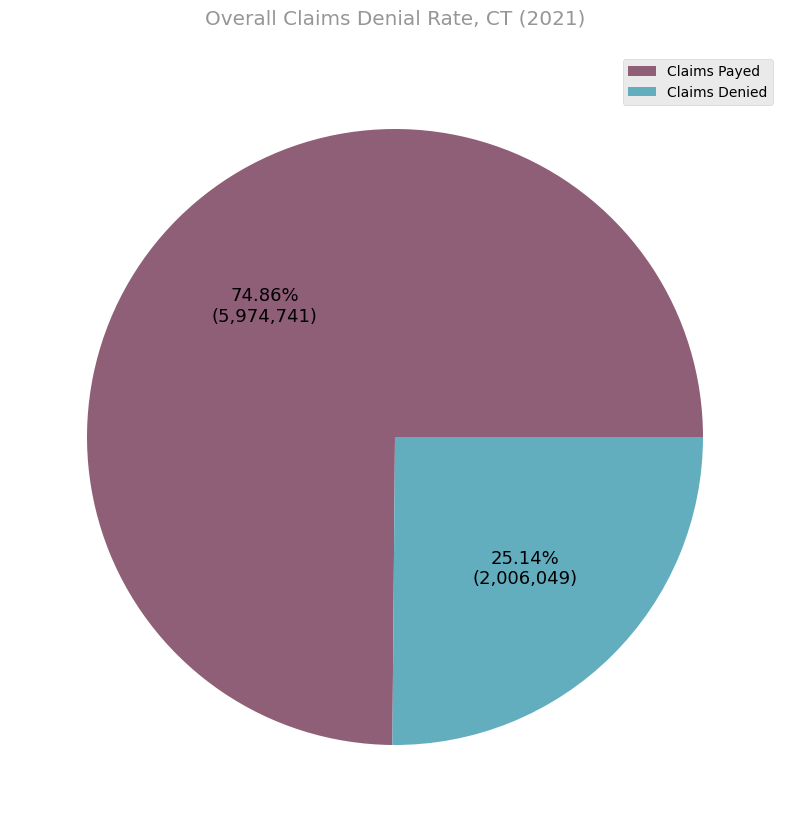

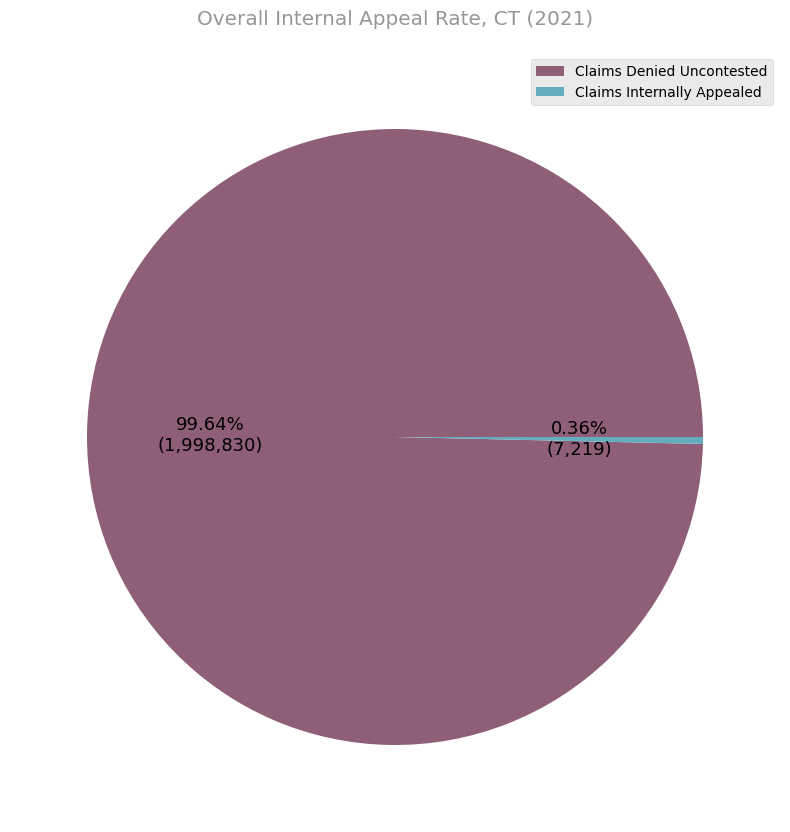

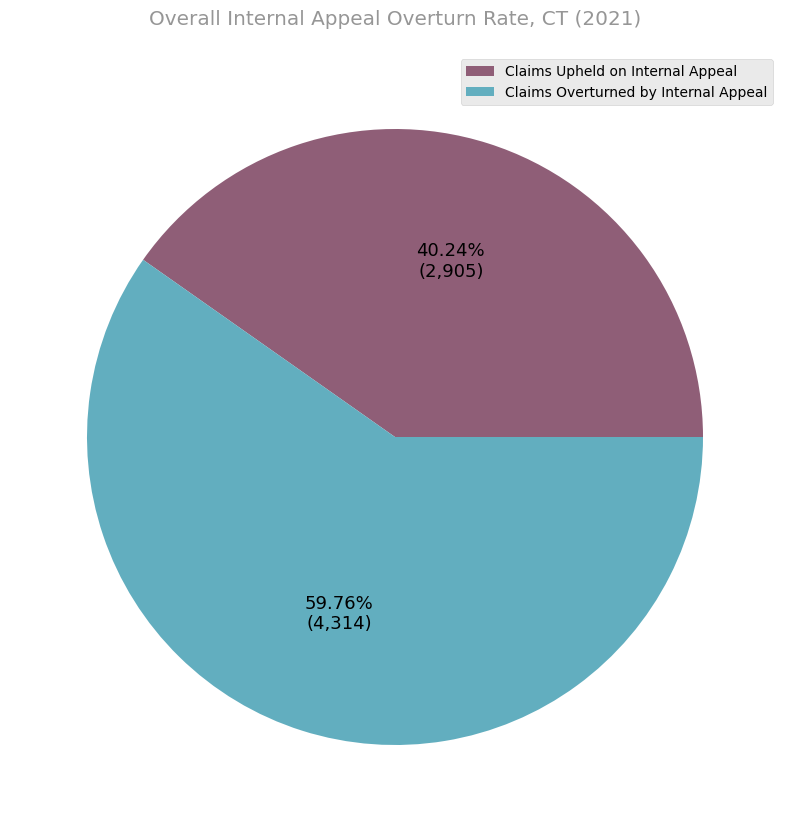

In [22]:
# Overall Denial Rates
claims_recvd = (
    denials_dict["hmo"]["claims_received"]
    + denials_dict["indemnity"]["claims_received"]
)
claims_denied = (
    denials_dict["hmo"]["claims_denied"] + denials_dict["indemnity"]["claims_denied"]
)
claims_appealed = (
    denials_dict["hmo"]["claims_appealed"]
    + denials_dict["indemnity"]["claims_appealed"]
)
claims_overturned = (
    denials_dict["hmo"]["claims_overturned"]
    + denials_dict["indemnity"]["claims_overturned"]
)


# Indemnity Plans Overall Denial Rate
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[
        claims_recvd - claims_denied,
        claims_denied,
    ],
    title=f"Overall Claims Denial Rate, CT (2021)" if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"overall_denial_pie.png"),
)

# Indemnity Plans Overall Appeal Rate
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[claims_denied - claims_appealed, claims_appealed],
    title=f"Overall Internal Appeal Rate, CT (2021)" if not NO_PLOT_TITLES else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"internal_appeal_rates_all_insurers.png"),
    show=True,
)

# Indemnity Plans Overall Appeal Success Rate
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[
        claims_appealed - claims_overturned,
        claims_overturned,
    ],
    title=f"Overall Internal Appeal Overturn Rate, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, f"internal_appeal_success_rates_all_insurers.png"
    ),
    show=True,
)

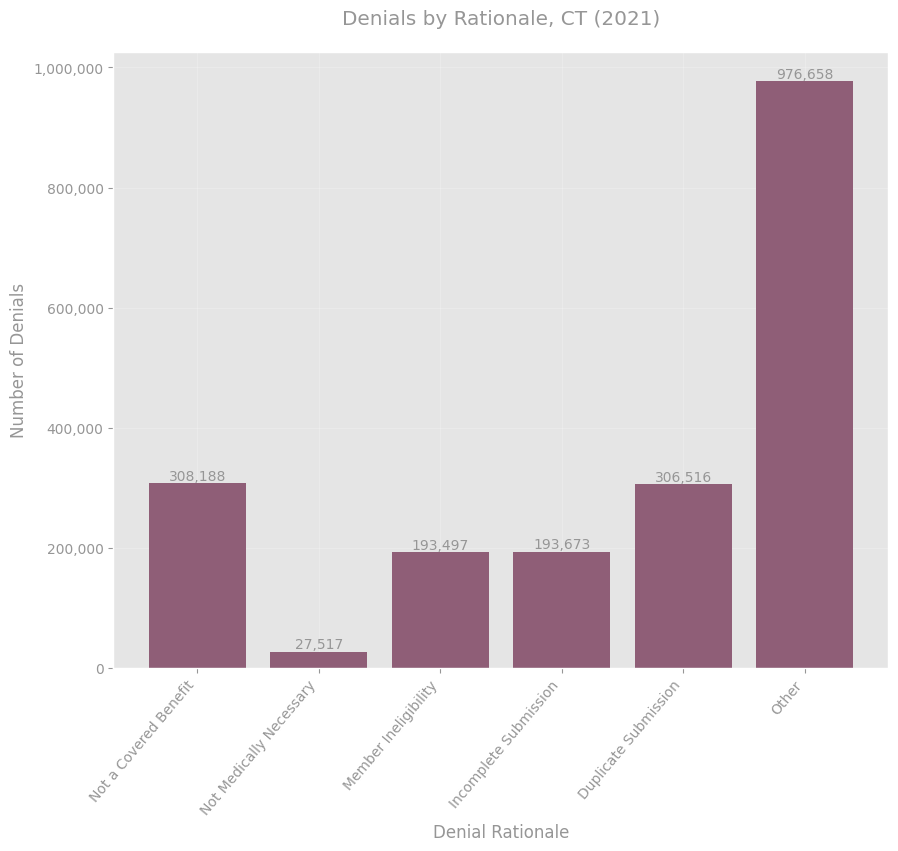

In [23]:
# Claims Denials By Rationale
total = pd.concat([hmo, ind]).reset_index()

# Breakdown Denials by Rationale
title = "Denials by Rationale, CT (2021)"
val_axis_label = "Number of Denials"
cat_axis_label = "Denial Rationale"
bar_names = [
    "Not a Covered Benefit",
    "Not Medically Necessary",
    "Member Ineligibility",
    "Incomplete Submission",
    "Duplicate Submission",
    "Other",
]
bar_vals = [total[col].sum() for col in total.columns[3:9]]
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denials_by_rationale.png"),
    figsize=(10, 8),
)

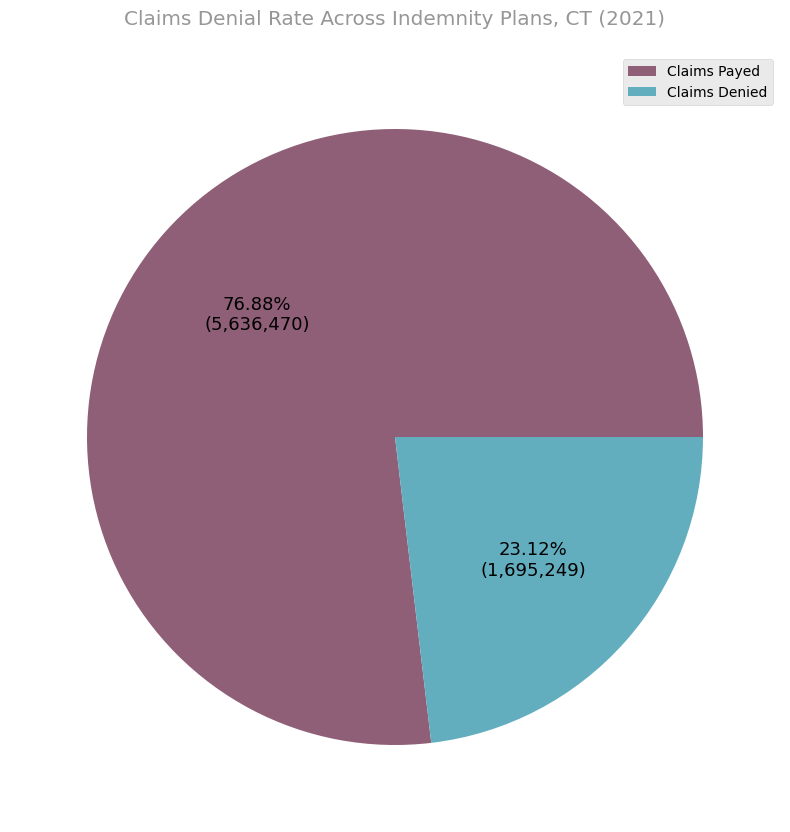

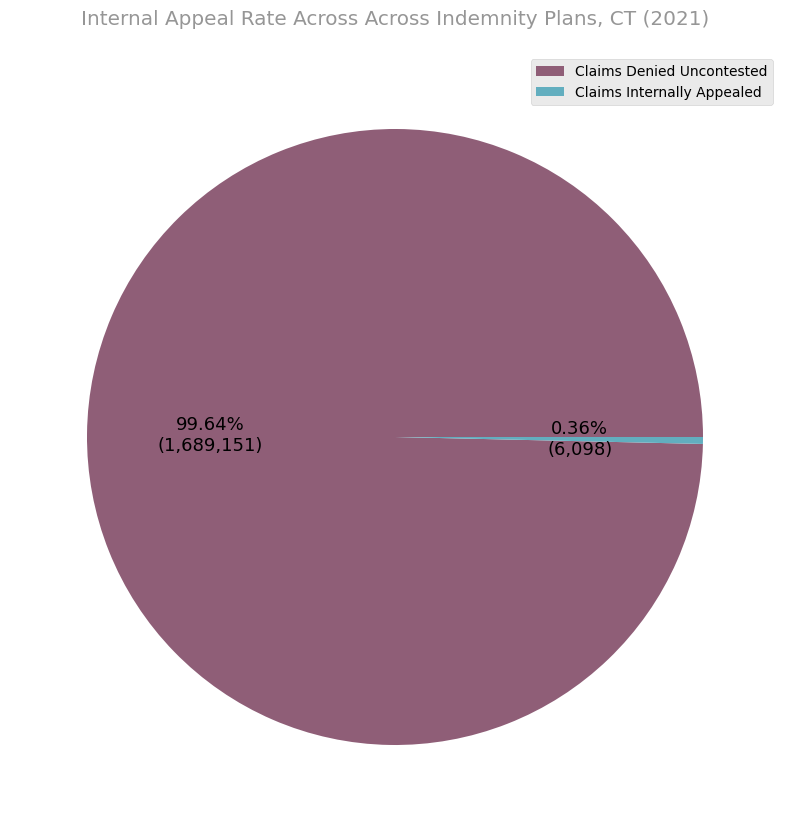

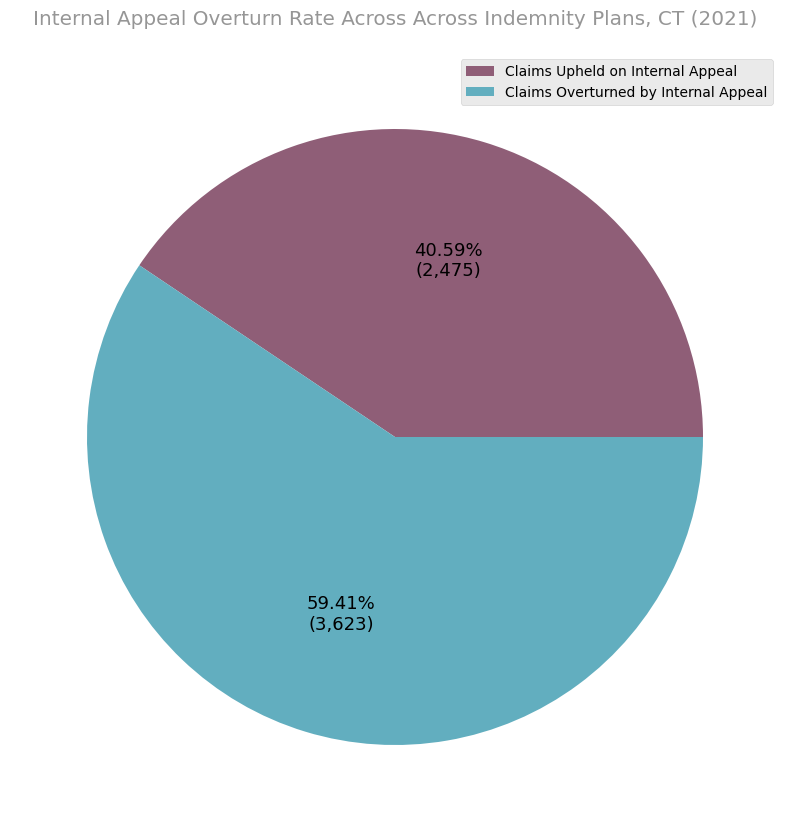

In [24]:
# Indemnity Specific plots
plan_type = "indemnity"
claims_recvd = denials_dict[plan_type]["claims_received"]
claims_denied = denials_dict[plan_type]["claims_denied"]
claims_appealed = denials_dict[plan_type]["claims_appealed"]
claims_overturned = denials_dict[plan_type]["claims_overturned"]


# Indemnity Plans Overall Denial Rate
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[
        claims_recvd - claims_denied,
        claims_denied,
    ],
    title=f"Claims Denial Rate Across {plan_type.capitalize()} Plans, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"{plan_type}_overall_denial_pie.png"),
)

# Indemnity Plans Overall Appeal Rate
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[claims_denied - claims_appealed, claims_appealed],
    title=f"Internal Appeal Rate Across Across {plan_type.capitalize()} Plans, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, f"{plan_type}_internal_appeal_rates_all_insurers.png"
    ),
    show=True,
)

# Indemnity Plans Overall Appeal Success Rate
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[
        claims_appealed - claims_overturned,
        claims_overturned,
    ],
    title=f"Internal Appeal Overturn Rate Across Across {plan_type.capitalize()} Plans, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, f"{plan_type}_internal_appeal_success_rates_all_insurers.png"
    ),
    show=True,
)

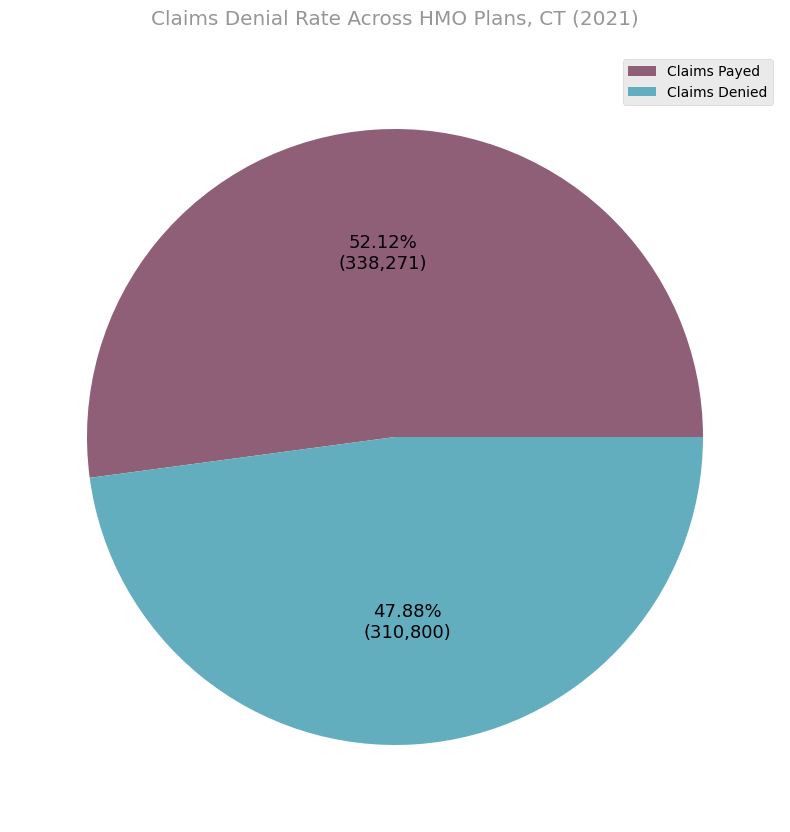

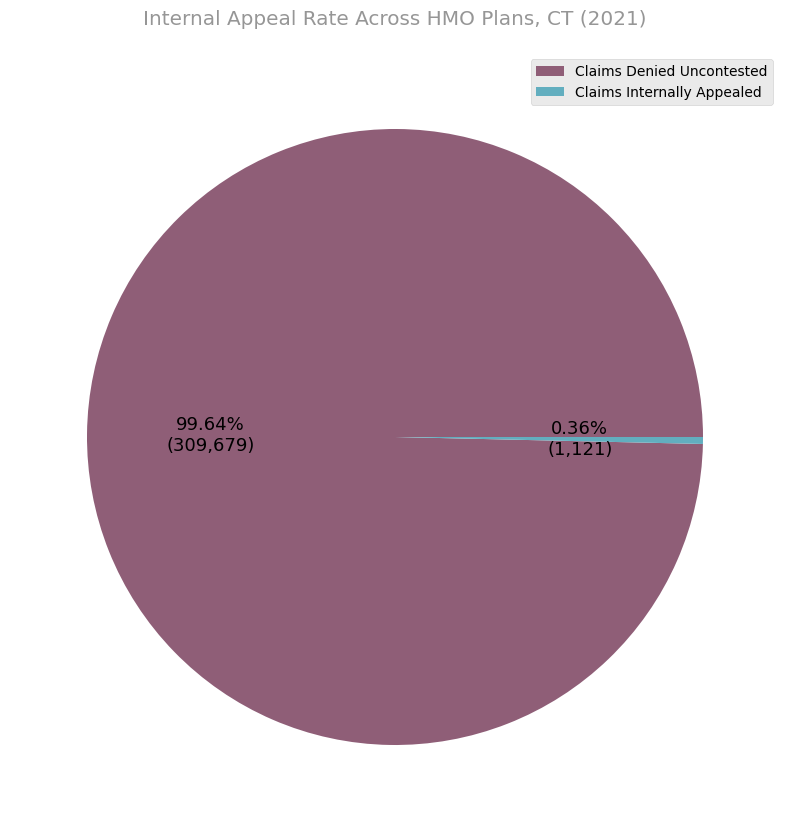

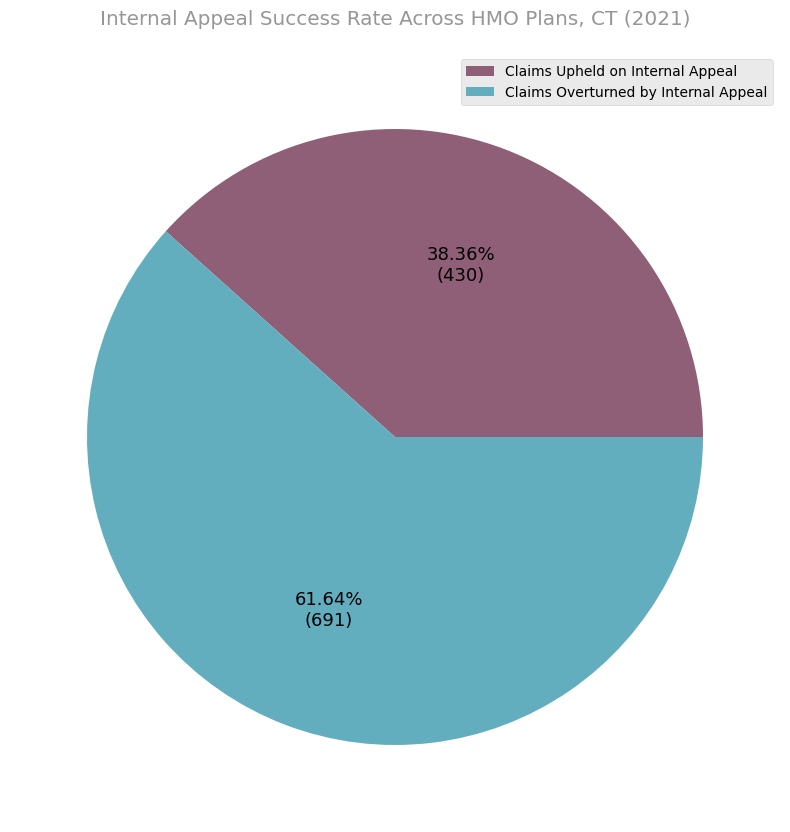

In [25]:
# HMO Specific plots
plan_type = "hmo"
claims_recvd = denials_dict[plan_type]["claims_received"]
claims_denied = denials_dict[plan_type]["claims_denied"]
claims_appealed = denials_dict[plan_type]["claims_appealed"]
claims_overturned = denials_dict[plan_type]["claims_overturned"]


# HMO Plans Overall Denial Rate
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[
        claims_recvd - claims_denied,
        claims_denied,
    ],
    title=f"Claims Denial Rate Across {plan_type.upper()} Plans, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"{plan_type}_overall_denial_pie.png"),
)

# HMO Plans Overall Appeal Rate
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[claims_denied - claims_appealed, claims_appealed],
    title=f"Internal Appeal Rate Across {plan_type.upper()} Plans, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, f"{plan_type}_internal_appeal_rates_all_insurers.png"
    ),
    show=True,
)

# HMO Plans Overall Appeal Success Rate
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[claims_appealed - claims_overturned, claims_overturned],
    title=f"Internal Appeal Success Rate Across {plan_type.upper()} Plans, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, f"{plan_type}_internal_appeal_success_rates_all_insurers.png"
    ),
    show=True,
)

In [26]:
all_insurers = pd.concat([hmo, ind]).groupby(["insurer"]).sum().reset_index()

# Recalculate rate fields
all_insurers = add_rates(all_insurers)

# Add Medical Necessity and Not Covered Determinations Denial Rates
all_insurers["nmn_denial_rate"] = (
    all_insurers["denials_nmn"] / all_insurers["claims_received"]
)
all_insurers["not_covered_denial_rate"] = (
    all_insurers["denials_not_covered"] / all_insurers["claims_received"]
)
all_insurers["denials_nc_or_nmn"] = (
    all_insurers["denials_nmn"] + all_insurers["denials_not_covered"]
)
all_insurers["nc_or_nmn_denial_rate"] = (
    all_insurers["denials_nc_or_nmn"] / all_insurers["claims_received"]
)

all_insurers["nmn_appeal_rate"] = (
    all_insurers["internal_appeals_nmn"] / all_insurers["denials_nmn"]
)

all_insurers["nmn_internal_appeal_overturn_rate"] = (
    all_insurers["internal_appeals_rev_nmn"] / all_insurers["internal_appeals_nmn"]
)


sorted_insurers = all_insurers.sort_values(by="claims_received", ascending=False)
display_cols = [
    "insurer",
    "claims_received",
    "denials",
    "internal_appeals",
    "internal_appeals_rev",
    "denial_rate",
    "internal_appeal_rate",
    "internal_appeal_overturn_rate",
    "nmn_denial_rate",
    "nmn_appeal_rate",
    "nmn_internal_appeal_overturn_rate",
]
sorted_insurers[display_cols]

,insurer,claims_received,denials,internal_appeals,internal_appeals_rev,denial_rate,internal_appeal_rate,internal_appeal_overturn_rate,nmn_denial_rate,nmn_appeal_rate,nmn_internal_appeal_overturn_rate
9,Oxford Health,2244431,355020,460,154,0.158178,0.001296,0.334783,0.000045,0.260000,0.076923
2,Anthem,1530457,197934,693,168,0.129330,0.003501,0.242424,0.000653,0.028028,0.178571
10,United,1079544,85296,252,64,0.079011,0.002954,0.253968,0.013434,0.002413,0.028571
3,CignaH & L,846719,141136,996,493,0.166686,0.007057,0.494980,0.011298,0.097742,0.466310
5,ConnectiCare Benefits,792411,675076,3771,2737,0.851927,0.005586,0.725802,0.001015,0.325871,0.454198
1,Aetna Life,709612,233636,54,12,0.329245,0.000231,0.222222,0.000018,0.153846,0.000000
8,Oxford,264740,49926,36,8,0.188585,0.000721,0.222222,0.000026,0.142857,0.000000
4,ConnectiCare,246937,232262,818,608,0.940572,0.003522,0.743276,0.001446,0.182073,0.584615
6,HPHC,174298,22531,90,47,0.129267,0.003994,0.522222,0.004401,0.100391,0.584416
7,Harvard,89657,12334,46,21,0.137569,0.003730,0.456522,0.004473,0.077307,0.612903


In [27]:
# Print Markdown table for report
# rename_map = {
#     "insurer": "Insurer",
#     "denial_rate": "Claims Denial Rate",
#     "internal_appeal_rate": "Internal Appeal Rate",
#     "internal_appeal_overturn_rate": "Internal Appeal Overturn Rate",
#     "claims_received": "Claims Received",
#     "denials": "Claims Denied",
#     "internal_appeals": "Internal Appeals",
#     "internal_appeals_rev": "Internal Appeal Overturns",
# }
# markdown_table = (
#     all_insurers[rename_map.keys()].rename(columns=rename_map).to_markdown()
# )
# print(markdown_table)

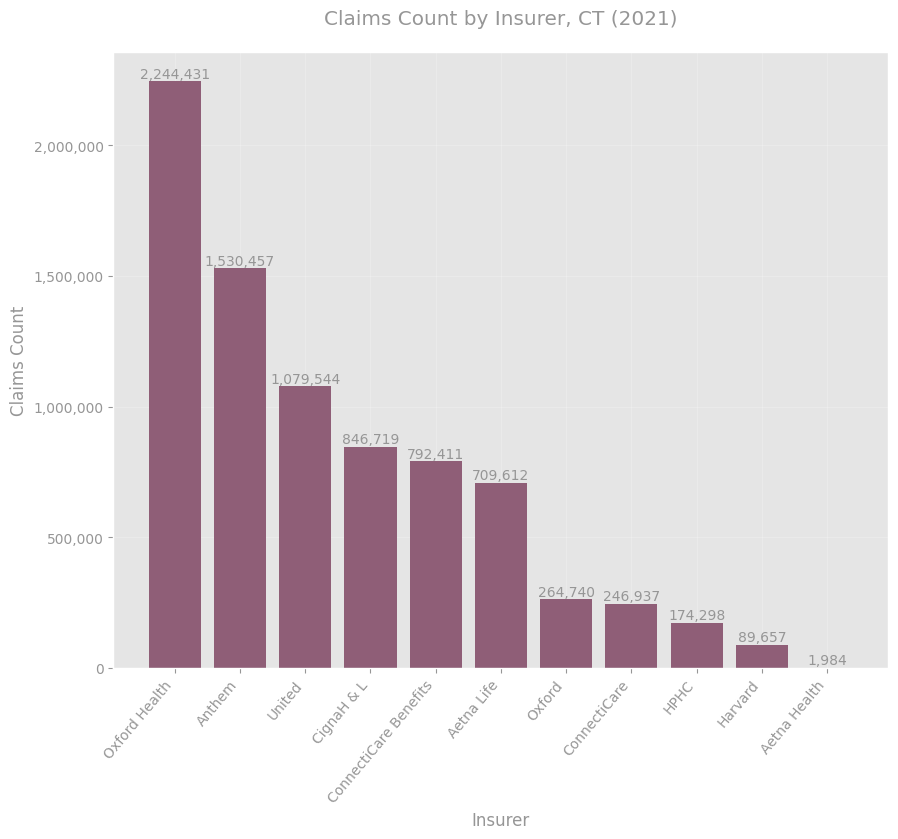

In [28]:
# Issuer Specific Claims and denial rates
bar_names = sorted_insurers["insurer"]
bar_vals = [round(x, 6) for x in sorted_insurers["claims_received"]]
val_axis_label = "Claims Count"
cat_axis_label = "Insurer"
title = "Claims Count by Insurer, CT (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "claims_by_insurer.png"),
    bar_label=True,
    int_vals=True,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
)

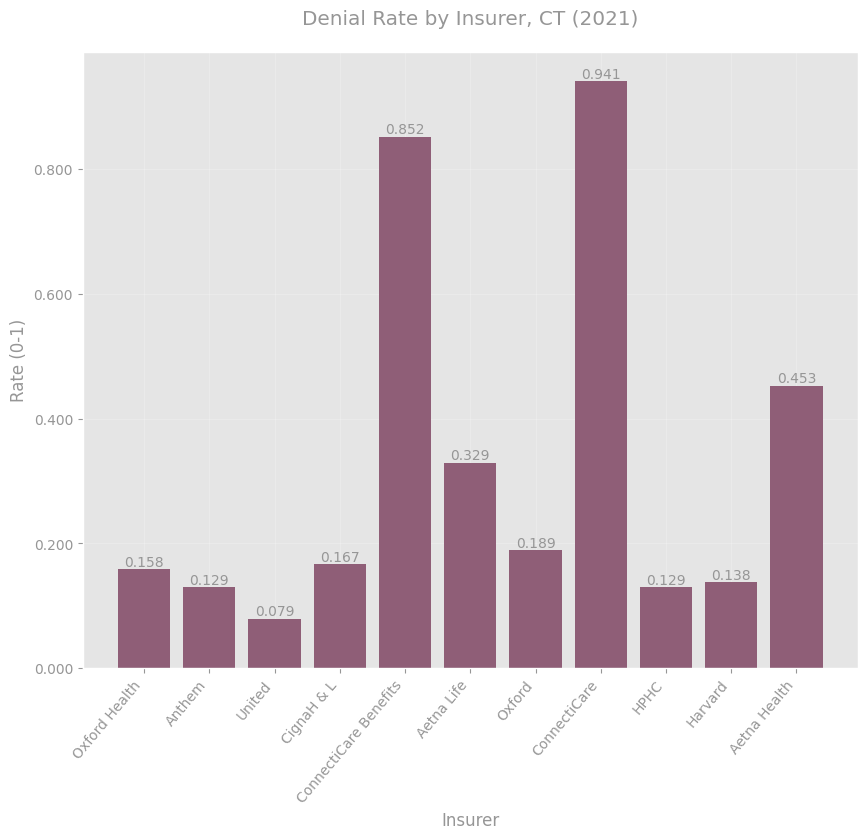

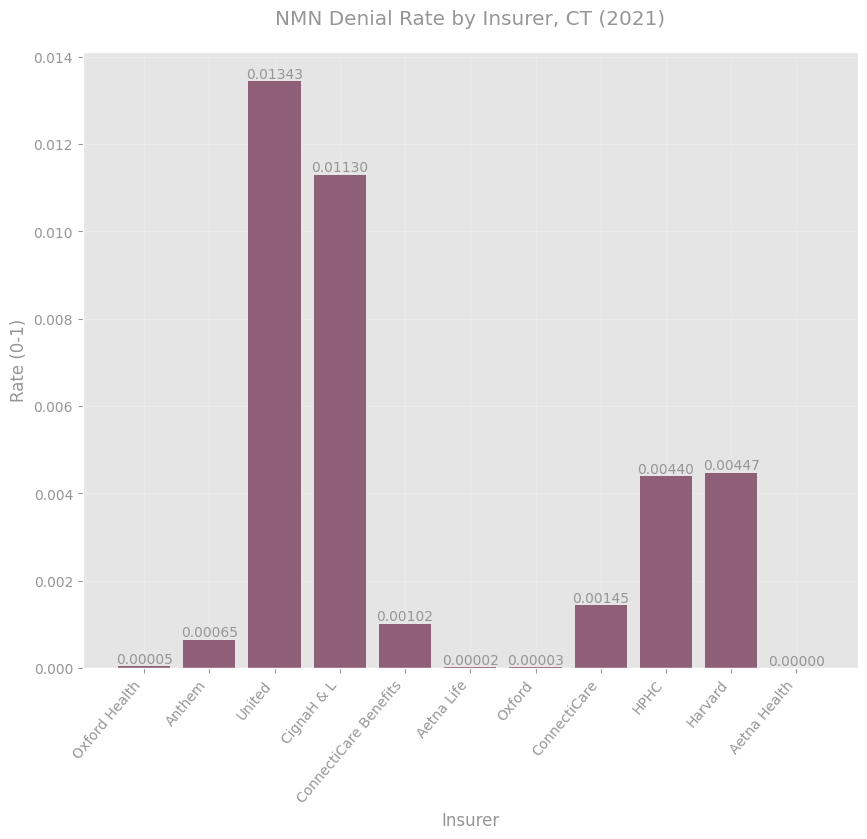

In [29]:
bar_vals = [round(x, 6) for x in sorted_insurers["denial_rate"]]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Denial Rate by Insurer, CT (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
)

bar_vals = [round(x, 6) for x in sorted_insurers["nmn_denial_rate"]]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "NMN Denial Rate by Insurer, CT (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
    float_precision_depth=5,
)

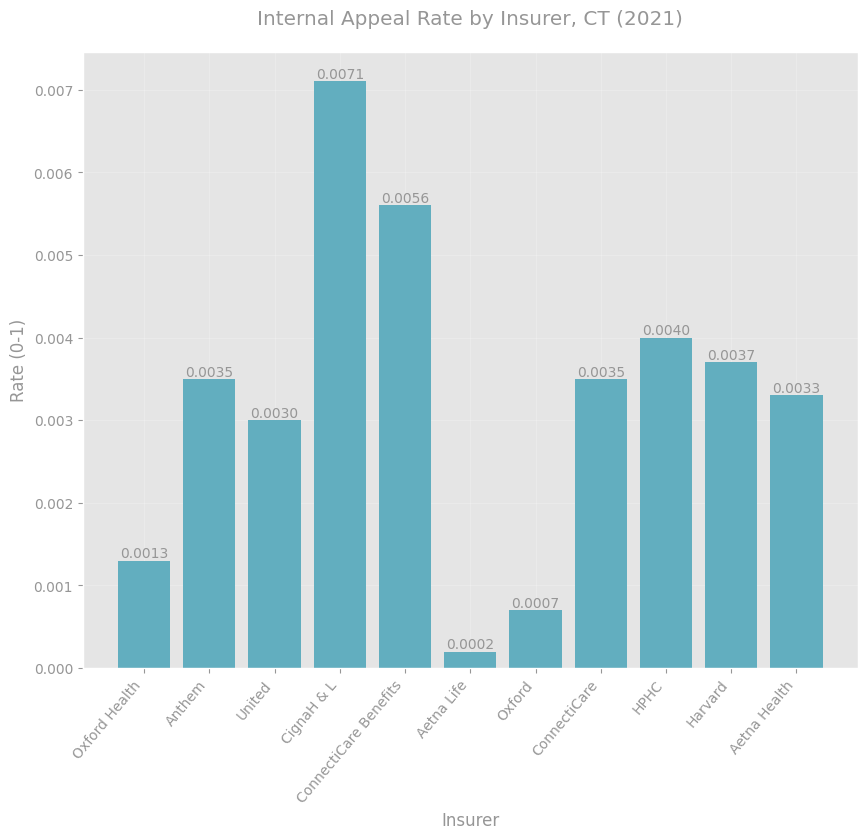

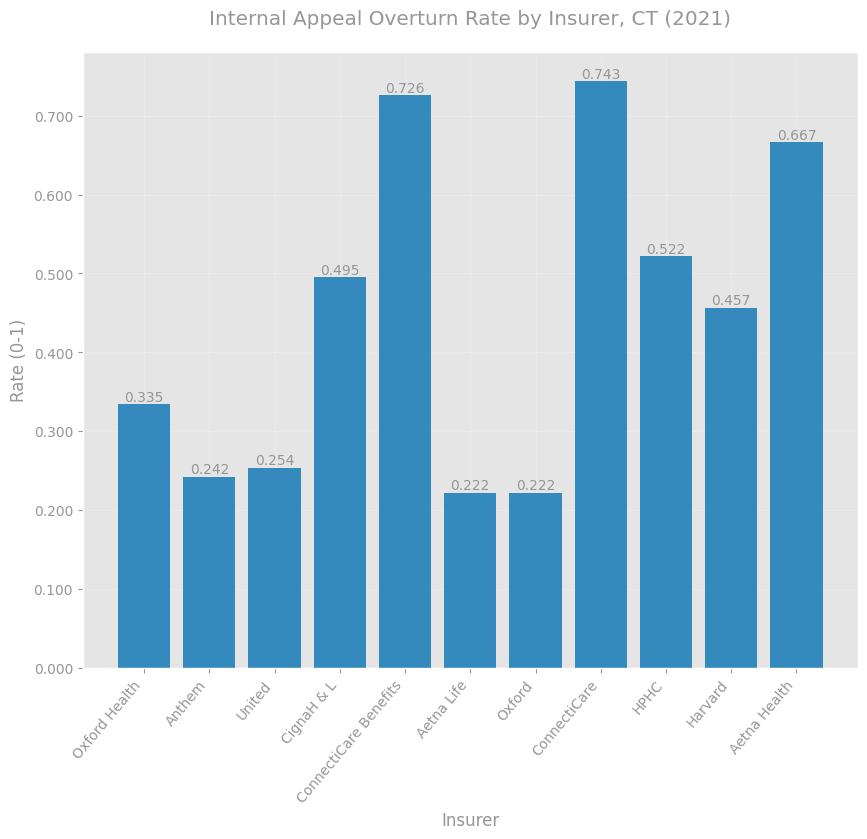

In [30]:
bar_vals = [round(x, 4) for x in sorted_insurers["internal_appeal_rate"]]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Internal Appeal Rate by Insurer, CT (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "appeal_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=SECONDARY_HEX,
    float_precision_depth=4,
    figsize=(10, 8),
)


bar_vals = [round(x, 6) for x in sorted_insurers["internal_appeal_overturn_rate"]]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Internal Appeal Overturn Rate by Insurer, CT (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_overturn_rate_by_insurer.png"
    ),
    bar_label=True,
    int_vals=False,
    color_hex=TERTIARY_HEX,
    figsize=(10, 8),
)

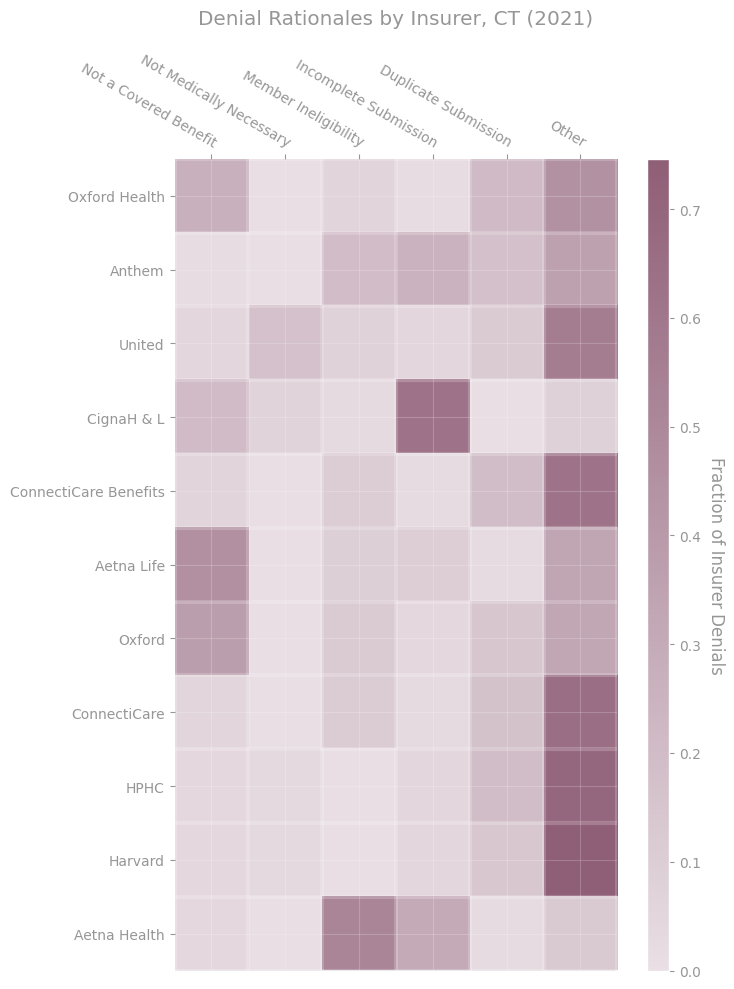

In [31]:
# Heatmap of denial rate types by insurer
denial_type_cats = [
    "denials_not_covered",
    "denials_nmn",
    "denials_non_eligible_enrollee",
    "denials_incomplete",
    "denials_duplicate",
    "denials_other",
]

bar_names = [
    "Not a Covered Benefit",
    "Not Medically Necessary",
    "Member Ineligibility",
    "Incomplete Submission",
    "Duplicate Submission",
    "Other",
]
insurers_col = "insurer"
total_denials_col = "denials"
insurer_list = list(sorted_insurers["insurer"])

arr = np.zeros((len(insurer_list), len(denial_type_cats)))
for idx, row in sorted_insurers.iterrows():
    try:
        row_idx = insurer_list.index(row[insurers_col])
        for col_idx, col in enumerate(denial_type_cats):
            denial_frac = row[col] / row[total_denials_col]
            arr[row_idx, col_idx] = denial_frac
    except ValueError as e:
        pass

fig, ax = plt.subplots(figsize=(10, 10))
if not NO_PLOT_TITLES:
    plt.title("Denial Rationales by Insurer, CT (2021)")

heat_val_name = f"Fraction of Insurer Denials"
im, cbar = heatmap(
    arr,
    insurer_list,
    bar_names,
    ax=ax,
    cmap=PRIMARY_CMAP,
    cbarlabel=heat_val_name,
    cbar_kw={"shrink": 0.3},
)

fig.tight_layout()
save_path = os.path.join(OUTPUT_IMAGE_DIR, "insurer_vs_denial_cat.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

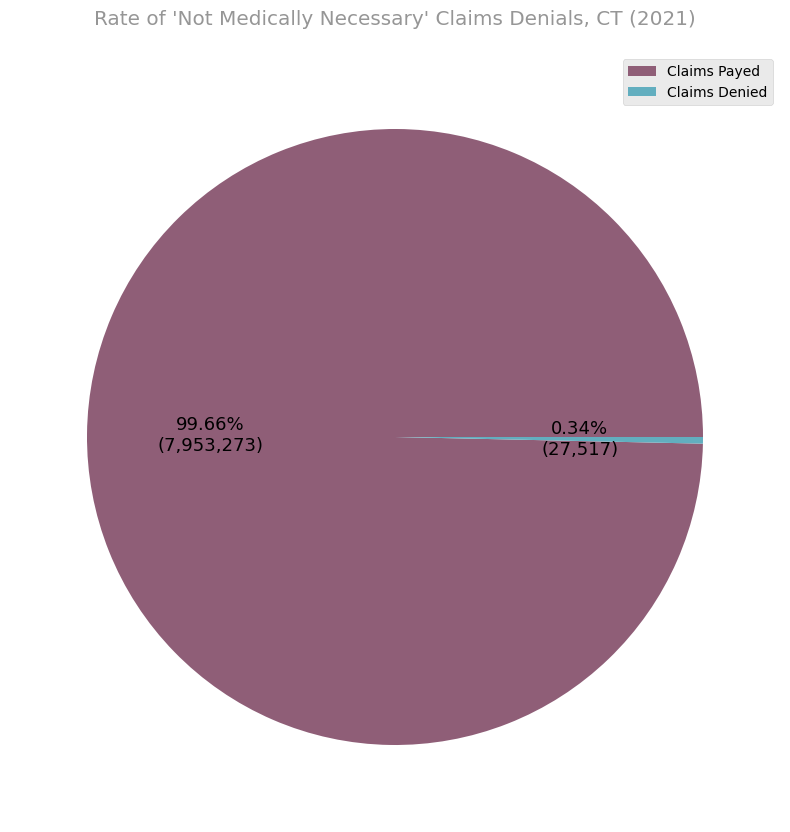

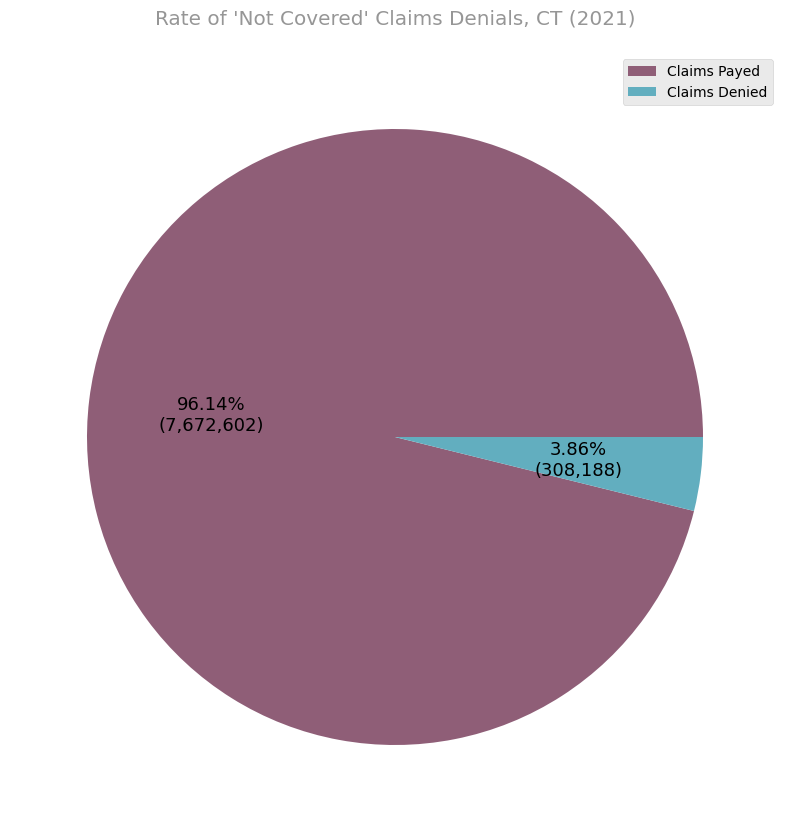

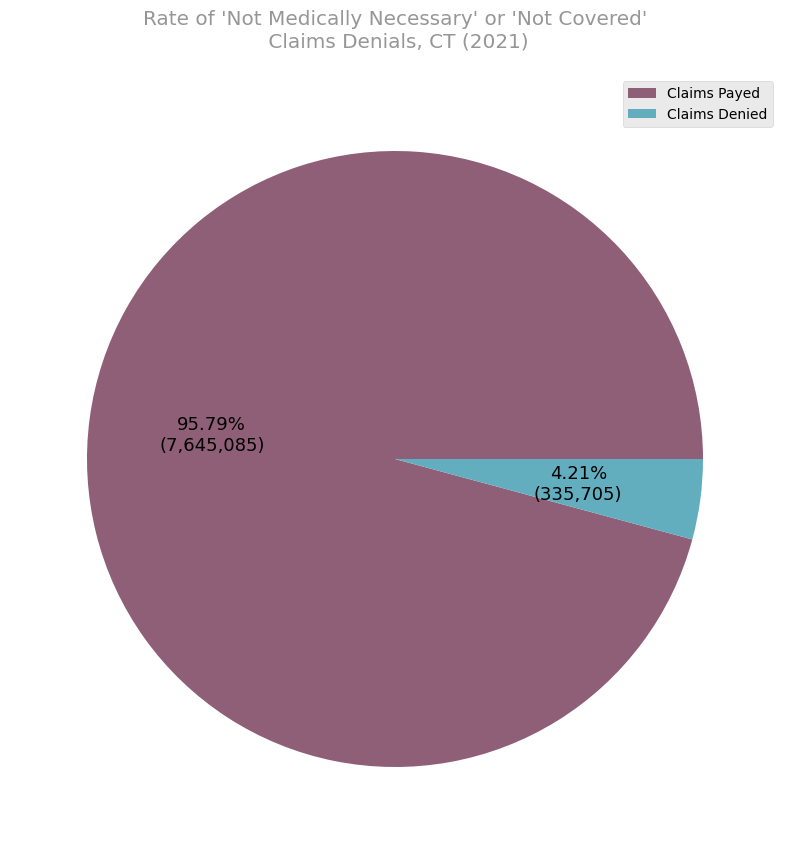

In [32]:
# Plot NMN Denial Rate, Not Covered DR, and Combined DR Across Data


# NMN Denial Rate
claims_recvd = all_insurers["claims_received"].sum()
claims_denied = all_insurers["denials_nmn"].sum()
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[
        claims_recvd - claims_denied,
        claims_denied,
    ],
    title=f"Rate of 'Not Medically Necessary' Claims Denials, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"nmn_denial_pie.png"),
)

# Not Covered Denial Rate
claims_recvd = all_insurers["claims_received"].sum()
claims_denied = all_insurers["denials_not_covered"].sum()
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[
        claims_recvd - claims_denied,
        claims_denied,
    ],
    title=f"Rate of 'Not Covered' Claims Denials, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"not_covered_denial_pie.png"),
    show=True,
)

# Combined Denial Rate
claims_recvd = all_insurers["claims_received"].sum()
claims_denied = all_insurers["denials_nc_or_nmn"].sum()
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[
        claims_recvd - claims_denied,
        claims_denied,
    ],
    title=f"Rate of 'Not Medically Necessary' or 'Not Covered'\n Claims Denials, CT (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"nc_or_nmn_denial_pie.png"),
    show=True,
)

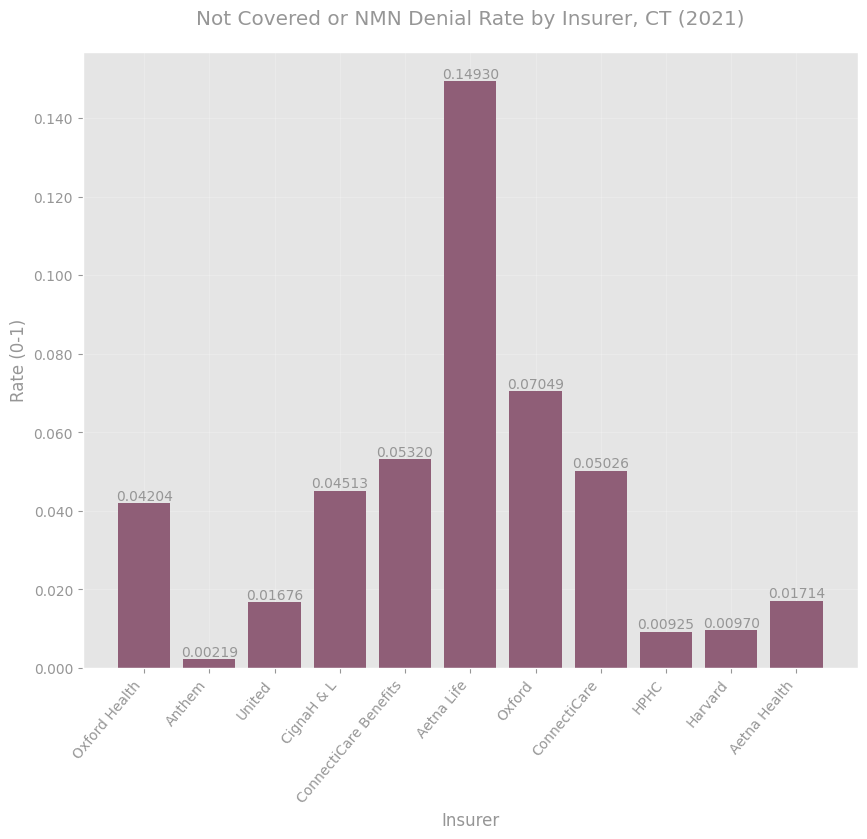

In [33]:
# NMN or Not Covered Denial Rate Breakdown Insurer
bar_names = sorted_insurers["insurer"]
bar_vals = [round(x, 6) for x in sorted_insurers["nc_or_nmn_denial_rate"]]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Not Covered or NMN Denial Rate by Insurer, CT (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nc_or_nmn_denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
    float_precision_depth=5,
)

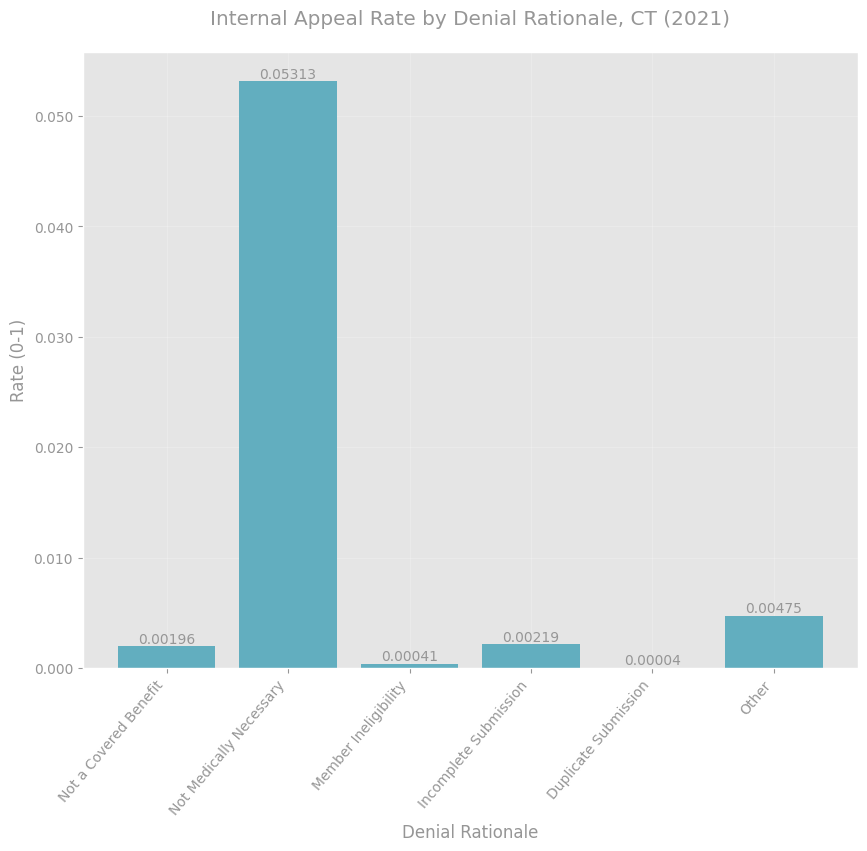

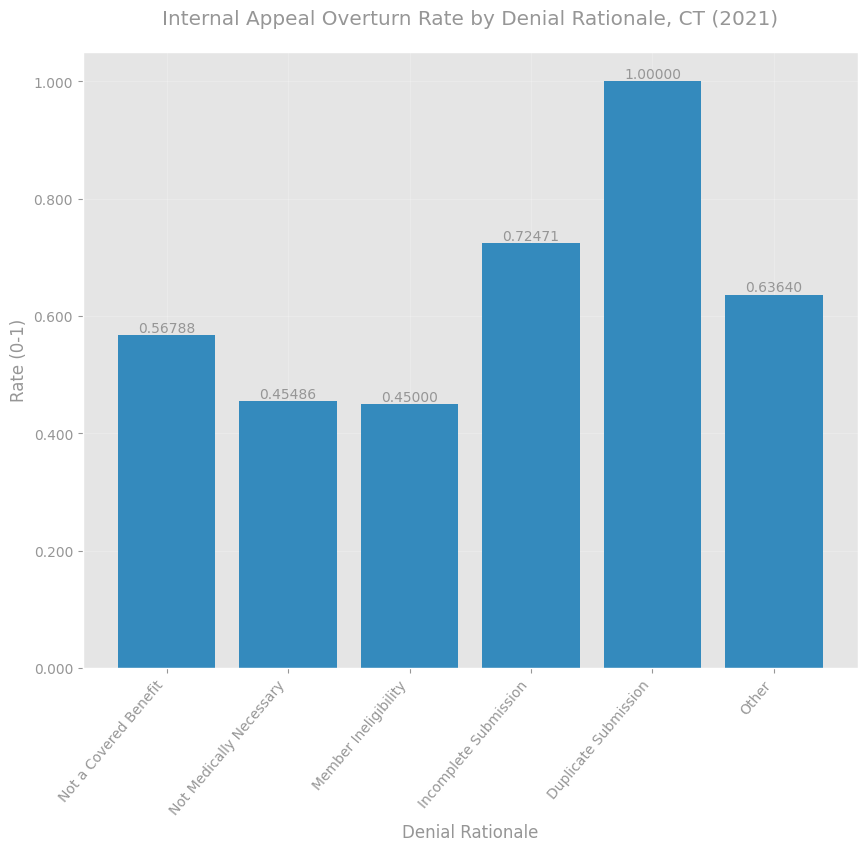

In [34]:
# Appeal rates and overturn rates by denial rationale

bar_names = [
    "Not a Covered Benefit",
    "Not Medically Necessary",
    "Member Ineligibility",
    "Incomplete Submission",
    "Duplicate Submission",
    "Other",
]
denial_col_names = list(sorted_insurers.columns[2:8])
appeal_col_names = list(sorted_insurers.columns[8:14])
appeal_overturn_col_names = list(sorted_insurers.columns[14:20])

title = "Internal Appeal Rate by Denial Rationale, CT (2021)"
val_axis_label = "Rate (0-1)"
cat_axis_label = "Denial Rationale"
bar_vals = []
for denials_col, appeals_col in zip(denial_col_names, appeal_col_names):
    appeals = sorted_insurers[appeals_col].sum()
    denials = sorted_insurers[denials_col].sum()
    bar_vals.append(appeals / denials)
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeals_by_rationale.png"),
    figsize=(10, 8),
    int_vals=False,
    float_precision_depth=5,
    color_hex=SECONDARY_HEX,
)

title = "Internal Appeal Overturn Rate by Denial Rationale, CT (2021)"
val_axis_label = "Rate (0-1)"
cat_axis_label = "Denial Rationale"
bar_vals = []
for appeals_col, overturns_col in zip(appeal_col_names, appeal_overturn_col_names):
    appeals = sorted_insurers[appeals_col].sum()
    overturns = sorted_insurers[overturns_col].sum()
    bar_vals.append(overturns / appeals)
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_overturns_by_rationale.png"
    ),
    figsize=(10, 8),
    int_vals=False,
    float_precision_depth=5,
    color_hex=TERTIARY_HEX,
)